# Assignment 6: Median Elimination for Stochastic Bandits

This notebook covers:
1. Median Elimination (PAC identification).
2. Comparison with Naive Explore-Then-Commit and UCB.
3. Reward and optimal-action plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [2]:
class StationaryBandit:
    def __init__(self, n_arms=10):
        self.n_arms = n_arms
        self.q_true = np.random.normal(0, 1, n_arms)

    def step(self, action):
        return np.random.normal(self.q_true[action], 1)

    def optimal_action(self):
        return int(np.argmax(self.q_true))

In [3]:
def run_ucb_experiment(runs=200, steps=5000, n_arms=10, c=2.0):
    avg_rewards = np.zeros(steps)
    optimal_actions = np.zeros(steps)

    for _ in range(runs):
        env = StationaryBandit(n_arms)
        q_est = np.zeros(n_arms)
        counts = np.zeros(n_arms)

        for t in range(steps):
            ucb = np.zeros(n_arms)
            for a in range(n_arms):
                if counts[a] == 0:
                    ucb[a] = float('inf')
                else:
                    ucb[a] = q_est[a] + c * np.sqrt(np.log(t + 1) / counts[a])

            action = int(np.argmax(ucb))
            reward = env.step(action)

            avg_rewards[t] += reward
            if action == env.optimal_action():
                optimal_actions[t] += 1

            counts[action] += 1
            q_est[action] += (reward - q_est[action]) / counts[action]

    return avg_rewards / runs, optimal_actions / runs


def run_naive_experiment(epsilon, delta, runs=200, steps=5000, n_arms=10):
    avg_rewards = np.zeros(steps)
    optimal_actions = np.zeros(steps)

    m = int(np.ceil((4.0 / (epsilon ** 2)) * np.log(2.0 * n_arms / delta)))
    total_exploration = m * n_arms

    for _ in range(runs):
        env = StationaryBandit(n_arms)
        arm_rewards = np.zeros(n_arms)
        arm_counts = np.zeros(n_arms)
        best_arm_cache = None

        for t in range(steps):
            if t < total_exploration:
                action = t % n_arms
                reward = env.step(action)

                arm_rewards[action] += reward
                arm_counts[action] += 1
            else:
                if best_arm_cache is None:
                    means = arm_rewards / np.maximum(arm_counts, 1)
                    best_arm_cache = int(np.argmax(means))
                action = best_arm_cache
                reward = env.step(action)

            avg_rewards[t] += reward
            if action == env.optimal_action():
                optimal_actions[t] += 1

    return avg_rewards / runs, optimal_actions / runs, total_exploration


def median_elimination(env, epsilon, delta):
    n_arms = env.n_arms
    active = list(range(n_arms))
    eps_l = epsilon / 4.0
    delta_l = delta / 2.0

    means = np.zeros(n_arms)
    counts = np.zeros(n_arms)

    exploration_actions = []
    exploration_rewards = []

    while len(active) > 1:
        prev_len = len(active)
        n_samples = int(np.ceil((1.0 / (2.0 * (eps_l ** 2))) * np.log(3.0 / delta_l)))

        for a in active:
            for _ in range(n_samples):
                reward = env.step(a)
                counts[a] += 1
                means[a] += (reward - means[a]) / counts[a]
                exploration_actions.append(a)
                exploration_rewards.append(reward)

        active_means = means[active]
        median_value = np.median(active_means)
        active = [a for a in active if means[a] >= median_value]

        if len(active) == prev_len:
            # If all means are tied, keep a random half to ensure progress
            perm = np.random.permutation(active)
            active = list(perm[:max(1, len(active) // 2)])

        eps_l *= 0.75
        delta_l *= 0.5

    return active[0], exploration_actions, exploration_rewards


def run_median_elimination_experiment(epsilon, delta, runs=200, steps=5000, n_arms=10):
    avg_rewards = np.zeros(steps)
    optimal_actions = np.zeros(steps)
    exploration_steps = []

    for _ in range(runs):
        env = StationaryBandit(n_arms)
        best_arm, exp_actions, exp_rewards = median_elimination(env, epsilon, delta)
        exploration_steps.append(len(exp_actions))

        t = 0
        for action, reward in zip(exp_actions, exp_rewards):
            if t >= steps:
                break
            avg_rewards[t] += reward
            if action == env.optimal_action():
                optimal_actions[t] += 1
            t += 1

        while t < steps:
            reward = env.step(best_arm)
            avg_rewards[t] += reward
            if best_arm == env.optimal_action():
                optimal_actions[t] += 1
            t += 1

    return avg_rewards / runs, optimal_actions / runs, int(np.mean(exploration_steps))

Running Median Elimination...
Running Naive Explore-Then-Commit...
Running UCB...
Median Elimination exploration steps (avg): 185839
Naive exploration steps: 23970


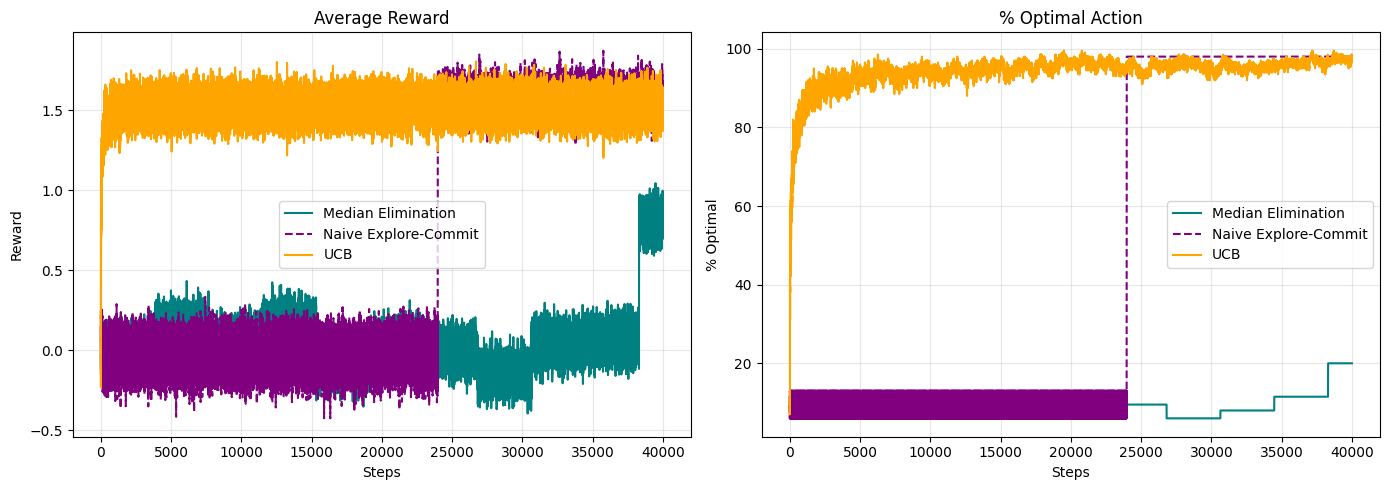

In [4]:
# Experiment settings
runs = 200
steps = 40000
epsilon = 0.1
delta = 0.05

print("Running Median Elimination...")
rew_me, opt_me, me_explore = run_median_elimination_experiment(epsilon, delta, runs, steps)

print("Running Naive Explore-Then-Commit...")
rew_naive, opt_naive, naive_explore = run_naive_experiment(epsilon, delta, runs, steps)

print("Running UCB...")
rew_ucb, opt_ucb = run_ucb_experiment(runs, steps)

print(f"Median Elimination exploration steps (avg): {me_explore}")
print(f"Naive exploration steps: {naive_explore}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(rew_me, label='Median Elimination', color='teal')
ax.plot(rew_naive, label='Naive Explore-Commit', color='purple', linestyle='--')
ax.plot(rew_ucb, label='UCB', color='orange')
ax.set_title('Average Reward')
ax.set_xlabel('Steps')
ax.set_ylabel('Reward')
ax.legend()

ax = axes[1]
ax.plot(opt_me * 100, label='Median Elimination', color='teal')
ax.plot(opt_naive * 100, label='Naive Explore-Commit', color='purple', linestyle='--')
ax.plot(opt_ucb * 100, label='UCB', color='orange')
ax.set_title('% Optimal Action')
ax.set_xlabel('Steps')
ax.set_ylabel('% Optimal')
ax.legend()

plt.tight_layout()
plt.show()